# Introduction to Transformers

# Initial Encoder-Decoder Architecture (Vaswani et al.)


## New Building Blocks 
### Learned Embeddings
This part of the Architecture is similar to the learned Embedding layer from last week, where we trained static embeddings for tokenized text. You can see the output of this layer as a static "starting point" for the vector representation of our token. We then change and move this static embedding using positional encoding (information about where in the text the token is), and based on the context. (what other tokens/words are around this one that are likely influence meaning and how?)
In practice this is a linear layer; think of a learned matrix of V rows and d_m columns. Each row is one unique word/token in the vocabulary, each column corresponds to one dimension in this vector space. 



### Positional Encoding
One big advantage of the transformer is that we can parallelize the training for each position in our sequence. To still maintain explicit knowledge of where in the text a word is we add a value to the learned static embeddings **based on position**. The initial formulation of this uses a sine-cosine pattern. Given a d_model-dimensional embedding we get the following encoding for even and odd positions and dimensions 0 to d_model
:

$$
PE_{(pos, d)} = 
\begin{cases} 
\sin\left(\frac{pos}{10000^{d/d_{model}}}\right) & \text{if } d \text{ is even} \\[10pt]
\cos\left(\frac{pos}{10000^{(d-1)/d_{model}}}\right) & \text{if } d \text{ is odd}
\end{cases}
$$

Q: Are they dependent on the input sequence? Whats the one variable that changes across Architectures in this case?


In [16]:
import numpy as np

def positional_encoding(max_len, dimension_model):
    pe = np.zeros((max_len, dimension_model))
    position = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
    #print(position, np.shape(position))
    # we do it in log space to avoidd overflow and save computation
    div_term = np.exp(np.arange(0, dimension_model, 2) * (np.log(10000.0) / dimension_model)) 
    #print(div_term,np.shape(div_term))
    pe[:, 0::2] = np.sin(position / div_term)  # Even indices
    pe[:, 1::2] = np.cos(position / div_term)  # Odd indices
    return pe

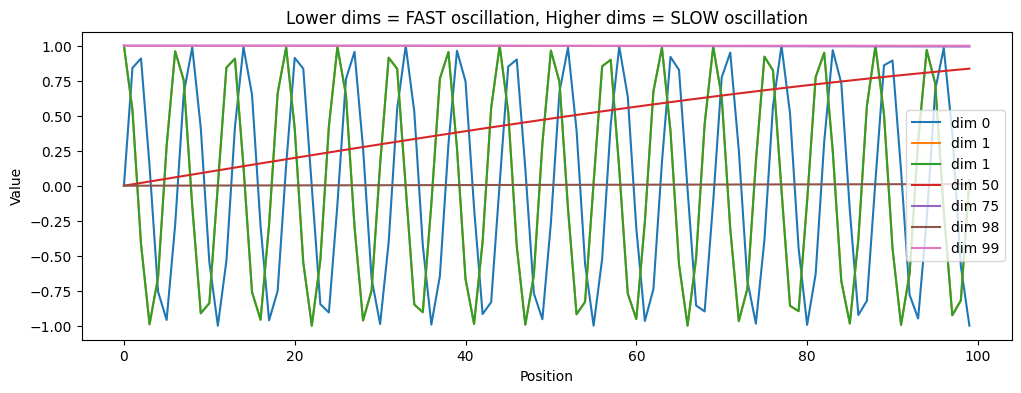

In [17]:
from matplotlib import pyplot as plt
dim_model = 100
max_length = 100
pe = positional_encoding(max_length,dim_model)

fig, ax = plt.subplots(figsize=(12, 4))

positions = np.arange(100)
for dim in [0,1, int(dim_model/max_length), int(dim_model/2), int(dim_model*3/4),dim_model-2,dim_model-1]:
    ax.plot(pe[:, dim], label=f'dim {dim}')

ax.set_xlabel('Position')
ax.set_ylabel('Value')
ax.set_title('Lower dims = FAST oscillation, Higher dims = SLOW oscillation')
ax.legend()
plt.show()

### Self-Attention Mechanism


So far we only have a static representation. Remember the issues of last time like "not very good". Or the two sentences:
"I caught a huge bass yesterday" and
"Turn up the bass on the speaker". 
We can see that the static approach does not suffice. For sequences its important to learn and add contextual information to our embeddings/vector representations. 
In vanilla transformers we do that with Self-Attention.

In slightly mathematical terms this attention mechanism has three steps for each position i:
1. define a measure of similarity and calc. it between the current tokens static embedding and every other token in the sequence.
   1. Cosine or Dot-Product
2. Scale the result by sqrt(d_model)
3. Pass through softmax to get attention weights

Remember that we can do this in parallel by doing matrix multiplication over the sequence. This step is also where we include our learned attention weights in forms of WQ, WK and WV. 

#### Formula (Single Head)
Given input $X \in \mathbb{R}^{n \times d_{model}}$, we compute:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

where $W_Q, W_K, W_V \in \mathbb{R}^{d_{model} \times d_k}$ are learned weight matrices.

The attention output is:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

- $QK^T \in \mathbb{R}^{n \times n}$ computes pairwise similarity scores
- $\sqrt{d_k}$ scaling prevents dot products from growing too large
- $\text{softmax}$ normalizes scores to attention weights per row (computationally this is the criminal)
- Multiplying by $V$ aggregates value vectors weighted by attention

In [18]:
import numpy as np

sentence1 = ["I", "caught", "a", "huge", "bass"]
sentence2 = ["turn", "up", "the", "bass"]

d_model = 4

# constructed
embeddings = {
    "I":      np.array([0.1, 0.0, 0.2, 0.0]),
    "caught": np.array([0.9, 0.0, 0.8, 0.1]),
    "a":      np.array([0.0, 0.0, 0.1, 0.1]),
    "huge":   np.array([0.7, 0.6, 0.0, 0.9]),
    "bass":   np.array([0.5, 0.5, 0.0, 0.0]),
    "turn":   np.array([0.0, 0.9, 0.8, 0.0]),
    "up":     np.array([0.0, 0.8, 0.3, 0.5]),
    "the":    np.array([0.1, 0.1, 0.1, 0.0]),
}

X = np.array([embeddings[w] for w in sentence1])
X2 = np.array([embeddings[w] for w in sentence2])
print("Input X shape:", X.shape)
print("X:\n", X.round(2))

Input X shape: (5, 4)
X:
 [[0.1 0.  0.2 0. ]
 [0.9 0.  0.8 0.1]
 [0.  0.  0.1 0.1]
 [0.7 0.6 0.  0.9]
 [0.5 0.5 0.  0. ]]


In [19]:
# learned matrices we use during this process for Q, K and V. Often dimensions are d_model x d_model...

#which dimensions should a token use when defining the query -> for bass that has 0.5, 0.5 we look for both fish feature and sound feature
W_Q = np.array([
    [1.0, 0.0, 0.5, 0.0],   
    [0.0, 1.0, 0.5, 0.0],   
    [0.2, 0.2, 0.5, 0.0],   
    [0.0, 0.0, 0.0, 0.5],
])

# what should i pay attention to when searching for fitting keys based on the query 
W_K = np.array([
    [1.0, 0.0, 0.0, 0.3],   # fish key boosted by size
    [0.0, 1.0, 0.0, 0.3],   # sound key boosted by size
    [0.4, 0.4, 0.5, 0.0],   
    [0.3, 0.3, 0.0, 0.5],   # size hints at category
])

#what information does a token provide when being attended to
W_V = np.array([
    [1.0, 0.0, 0.3, 0.0],   # fish value enhanced by action
    [0.0, 1.0, 0.3, 0.0],   # sound value enhanced by action
    [0.0, 0.0, 0.8, 0.0],
    [0.0, 0.0, 0.0, 0.8],
])

In [20]:
# project static + positional input sequence embeddings
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

Q2 = X2 @ W_Q
K2 = X2 @ W_K
V2 = X2 @ W_V

In [21]:
# compute attention weights/scores (dot product)
# evry position scores[i, j] is the dot product of Q[i] and K[j]
scores = Q @ K.T
print("Scores shape:", scores.shape)
print("Scores:\n", scores.round(3))

scores2 = Q2 @ K2.T
print("Scores sentence 2 shape:", scores2.shape)
print("Scores sentence 2:\n", scores2.round(3))



Scores shape: (5, 5)
Scores:
 [[0.043 0.249 0.02  0.171 0.09 ]
 [0.29  1.737 0.13  1.209 0.625]
 [0.012 0.068 0.008 0.079 0.035]
 [0.252 1.489 0.146 1.579 0.785]
 [0.18  1.    0.095 0.92  0.5  ]]
Scores sentence 2 shape: (4, 4)
Scores sentence 2:
 [[1.684 1.305 0.213 0.61 ]
 [1.356 1.141 0.171 0.535]
 [0.245 0.183 0.041 0.12 ]
 [0.97  0.745 0.165 0.5  ]]


In [22]:
# scale itttt
scores = scores / np.sqrt(d_model) 
print("Scores shape:", scores.shape)
print("Scores:\n", scores.round(3))

scores2 = scores2 / np.sqrt(d_model) 
print("Scores sentence 2 shape:", scores2.shape)
print("Scores sentence 2:\n", scores2.round(3))

Scores shape: (5, 5)
Scores:
 [[0.022 0.125 0.01  0.085 0.045]
 [0.145 0.869 0.065 0.605 0.313]
 [0.006 0.034 0.004 0.039 0.018]
 [0.126 0.744 0.073 0.789 0.392]
 [0.09  0.5   0.048 0.46  0.25 ]]
Scores sentence 2 shape: (4, 4)
Scores sentence 2:
 [[0.842 0.652 0.107 0.305]
 [0.678 0.571 0.086 0.268]
 [0.122 0.092 0.021 0.06 ]
 [0.485 0.372 0.082 0.25 ]]


In [23]:
# softmax so it scales up to 1
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / exp_x.sum(axis=-1, keepdims=True)

attention_weights = softmax(scores)
print("\nAttention weights (rows sum to 1):\n", attention_weights.round(5))
print("Row sums:", attention_weights.sum(axis=1).round(3))

attention_weights2 = softmax(scores2)
print("\nAttention weights sentence 2 (rows sum to 1):\n", attention_weights2.round(5))
print("Row sums:", attention_weights2.sum(axis=1).round(3))



Attention weights (rows sum to 1):
 [[0.19283 0.21371 0.1906  0.20549 0.19738]
 [0.14814 0.30539 0.13677 0.23457 0.17514]
 [0.19714 0.20277 0.19676 0.20387 0.19945]
 [0.14184 0.26322 0.13449 0.27533 0.18512]
 [0.1643  0.24757 0.15746 0.23786 0.19281]]
Row sums: [1. 1. 1. 1. 1.]

Attention weights sentence 2 (rows sum to 1):
 [[0.34593 0.28614 0.16578 0.20215]
 [0.32106 0.28841 0.17756 0.21297]
 [0.2623  0.25436 0.2369  0.24644]
 [0.29826 0.26652 0.19943 0.23579]]
Row sums: [1. 1. 1. 1.]


In [24]:
output1 = attention_weights @ V
output2 = attention_weights2 @ V2

bass_idx1 = sentence1.index("bass")
bass_idx2 = sentence2.index("bass")

print("Sentence 1:", sentence1)
print(f"'bass' original embedding:      {embeddings['bass']}")
print(f"'bass' contextualized:          {output1[bass_idx1].round(3)}")

print("\nSentence 2:", sentence2)
print(f"'bass' original embedding:      {embeddings['bass']}")
print(f"'bass' contextualized:          {output2[bass_idx2].round(3)}")

Sentence 1: ['I', 'caught', 'a', 'huge', 'bass']
'bass' original embedding:      [0.5 0.5 0.  0. ]
'bass' contextualized:          [0.502 0.239 0.42  0.204]

Sentence 2: ['turn', 'up', 'the', 'bass']
'bass' original embedding:      [0.5 0.5 0.  0. ]
'bass' contextualized:          [0.138 0.619 0.498 0.107]


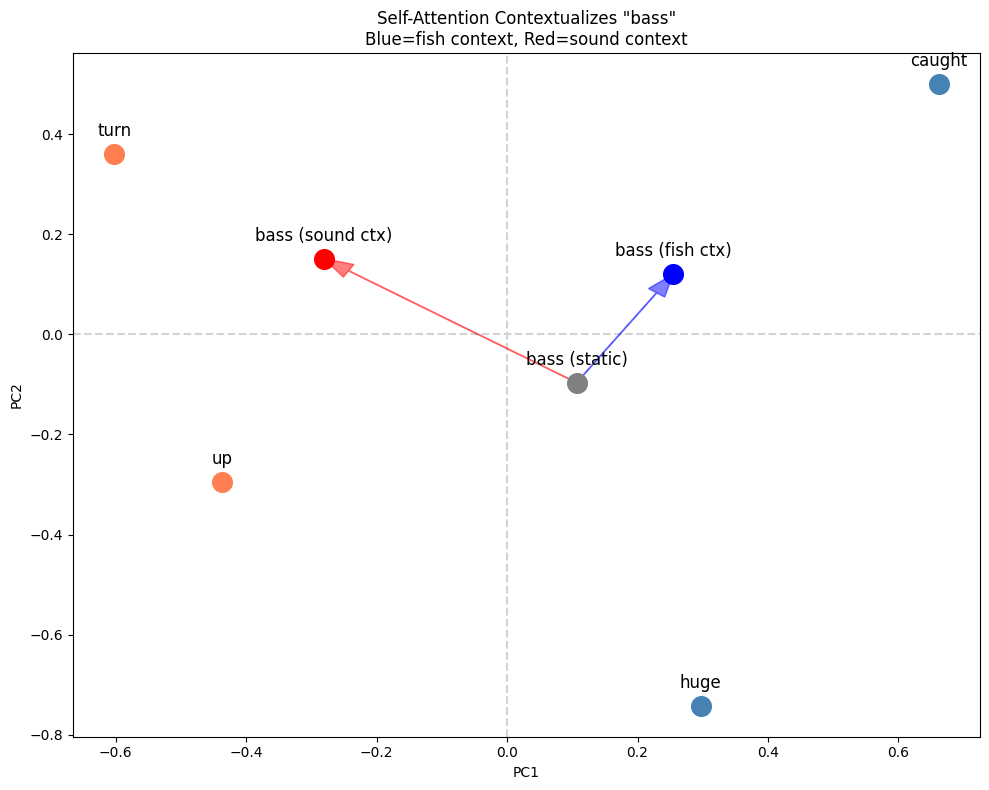

Distances from contextualized 'bass' to vocab:
  bass(fish ctx) → caught: 0.609
  bass(fish ctx) → huge:   0.911
  bass(fish ctx) → turn:   0.935
  bass(fish ctx) → up:     0.818

  bass(sound ctx) → caught: 1.028
  bass(sound ctx) → huge:   1.093
  bass(sound ctx) → turn:   0.447
  bass(sound ctx) → up:     0.496


In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

bass_static = embeddings['bass']
bass_ctx1 = output1[sentence1.index("bass")]
bass_ctx2 = output2[sentence2.index("bass")]

all_embeddings = np.array([
    embeddings['caught'],
    embeddings['huge'],
    embeddings['turn'],
    embeddings['up'],
    bass_static,
    bass_ctx1,
    bass_ctx2,
])
labels = ['caught', 'huge', 'turn', 'up', 'bass (static)', 'bass (fish ctx)', 'bass (sound ctx)']
colors = ['steelblue', 'steelblue', 'coral', 'coral', 'gray', 'blue', 'red']

pca = PCA(n_components=2)
projected = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(projected):
    plt.scatter(x, y, c=colors[i], s=200, zorder=5)
    plt.annotate(labels[i], (x, y), fontsize=12, ha='center', va='bottom', 
                 xytext=(0, 10), textcoords='offset points')

plt.axhline(y=0, color='lightgray', linestyle='--', zorder=1)
plt.axvline(x=0, color='lightgray', linestyle='--', zorder=1)

plt.arrow(projected[4,0], projected[4,1], 
          projected[5,0]-projected[4,0], projected[5,1]-projected[4,1],
          head_width=0.03, color='blue', alpha=0.5, length_includes_head=True)
plt.arrow(projected[4,0], projected[4,1], 
          projected[6,0]-projected[4,0], projected[6,1]-projected[4,1],
          head_width=0.03, color='red', alpha=0.5, length_includes_head=True)

plt.title('Self-Attention Contextualizes "bass"\nBlue=fish context, Red=sound context')
plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.tight_layout()
plt.show()

print("Distances from contextualized 'bass' to vocab:")
print(f"  bass(fish ctx) → caught: {np.linalg.norm(bass_ctx1 - embeddings['caught']):.3f}")
print(f"  bass(fish ctx) → huge:   {np.linalg.norm(bass_ctx1 - embeddings['huge']):.3f}")
print(f"  bass(fish ctx) → turn:   {np.linalg.norm(bass_ctx1 - embeddings['turn']):.3f}")
print(f"  bass(fish ctx) → up:     {np.linalg.norm(bass_ctx1 - embeddings['up']):.3f}")
print()
print(f"  bass(sound ctx) → caught: {np.linalg.norm(bass_ctx2 - embeddings['caught']):.3f}")
print(f"  bass(sound ctx) → huge:   {np.linalg.norm(bass_ctx2 - embeddings['huge']):.3f}")
print(f"  bass(sound ctx) → turn:   {np.linalg.norm(bass_ctx2 - embeddings['turn']):.3f}")
print(f"  bass(sound ctx) → up:     {np.linalg.norm(bass_ctx2 - embeddings['up']):.3f}")

### Multi-Head Attention

## Encoder vs Decoder vs Encoder-Decoder Architecture


# Encoder Practical Example: IMDB again


In [26]:
# model init
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # smol little transformer


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  
    problem_type="single_label_classification"
)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model: {MODEL_NAME}")
print(f"Parameters: {num_params:,}")
print(f"Device: {next(model.parameters()).device}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model moved to: {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: sentence-transformers/all-MiniLM-L6-v2
Parameters: 22,713,986
Device: cpu
Model moved to: cuda


In [27]:
from torchinfo import summary
dummy_input = tokenizer("Example text", return_tensors="pt", padding="max_length", max_length=128)
dummy_input = {k: v.to(device) for k, v in dummy_input.items()}

summary(model, input_data=dummy_input)
summary(
    model,
    input_size=(1, 128), 
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
BertForSequenceClassification (BertForSequenceClassification)          [1, 128]             [1, 2]               --                   True
├─BertModel (bert)                                                     [1, 128]             [1, 384]             --                   True
│    └─BertEmbeddings (embeddings)                                     --                   [1, 128, 384]        --                   True
│    │    └─Embedding (word_embeddings)                                [1, 128]             [1, 128, 384]        11,720,448           True
│    │    └─Embedding (token_type_embeddings)                          [1, 128]             [1, 128, 384]        768                  True
│    │    └─Embedding (position_embeddings)                            [1, 128]             [1, 128, 384]        196,608              True
│    │    └─LayerNorm 

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import evaluate
import numpy as np
MAX_LEN = 512
BATCH_SIZE = 32
EPOCHS = 5

dataset = load_dataset("imdb")

test_split = dataset["test"].train_test_split(test_size=0.5, seed=42)
dataset["val"] = test_split["train"]
dataset["test"] = test_split["test"]

print(f"Training samples:   {len(dataset['train']):,}")
print(f"Validation samples: {len(dataset['val']):,}")
print(f"Test samples:       {len(dataset['test']):,}")

tokenize = lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
)

trainer.train()

Training samples:   25,000
Validation samples: 12,500
Test samples:       12,500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.232900,0.206586,0.918240
2,0.164900,0.188211,0.927440
3,0.128500,0.226645,0.930480
4,0.065000,0.264297,0.930880
5,0.039800,0.282927,0.933280


TrainOutput(global_step=3910, training_loss=0.13990636770530124, metrics={'train_runtime': 723.9748, 'train_samples_per_second': 172.658, 'train_steps_per_second': 5.401, 'total_flos': 4145726208000000.0, 'train_loss': 0.13990636770530124, 'epoch': 5.0})

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

results = trainer.evaluate(dataset["test"])
print(f"Test Loss: {results['eval_loss']:.4f}")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")

preds = trainer.predict(dataset["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))
print(confusion_matrix(y_true, y_pred))

Test Loss: 0.3097
Test Accuracy: 0.9278
              precision    recall  f1-score   support

    negative       0.93      0.92      0.93      6267
    positive       0.92      0.94      0.93      6233

    accuracy                           0.93     12500
   macro avg       0.93      0.93      0.93     12500
weighted avg       0.93      0.93      0.93     12500

[[5766  501]
 [ 401 5832]]
